## 引言

前面一章中，我们探索了一个回归任务：预测房价。实践中使用了多种算法，如线性回归、决策树以及随机森林。

现在将问题转到分类问题上了。

In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## MNIST数据集

MNIST手写数字数据集是由美国国家标准与技术研究院在20世纪80年代收集得到，用于对手写数据进行识别。
总共包含70000张大小为28 X 28 像素的图片。

In [1]:
# 获取数据
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')

/Users/pzhang/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/pzhang/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

mnist 是一个字典：

- `DESCR` 描述数据集
- `data` 存放数据，一行为一个样本
- `target` 存放标签

In [5]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

MNIST 数据集包含70000张图片，每张图片有784个特征：为28*28像素的图片，每张图片为8位灰度图，值介于0-255之间。

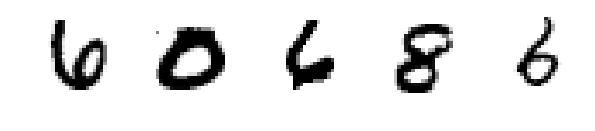

[6. 0. 6. 8. 6.]


In [23]:
# 随机查看一下5张图片
idx = np.random.choice(X.shape[0], 5)
some_digit = X[idx]
some_label = y[idx]

fig, axes = plt.subplots(1, 5, figsize=(10, 3))

for i, ax in enumerate(axes):
    ax.imshow(some_digit[i].reshape(28, 28), cmap=plt.cm.binary)
    ax.axis('off')
    
plt.show()

print(some_label)

可以看到，对应的标签即是图片的数字大小。

### 划分测试集

在进行机器学习数据训练前，先在数据集中划分出一个测试集放在一旁，以便最后来测试我们算法的性能。

MNIST数据集已经事先分好了训练集（前60000个样本）和测试集（后10000个样本）：

In [25]:
(X_train, y_train), (X_test, y_test) = (X[:60000], y[:60000]), (X[60000:], y[60000:])

现在我们需要将训练集打乱，以保证后面做交叉验证时，每一个fold都是相似的，而不会出现一个fold中出现大量的同一个数字。

In [28]:
shuffle_index = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 训练一个二分类器

在进行多分类任务之前，我们先简化一下任务：只尝试去识别一个数字，比如说数字5。这个数字5检测器就是一个二分类器，识别5和非5两类。现在创建训练和测试的标签：

In [32]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

作为一个开始，选用随机梯度下降（SGD）来进行训练。scikie-learn中的 `SGDZClassfier` 的优点是可以高效处理很大的数据集。这是因为SGD一次只处理一个样本，这也使得SGD适合在线学习（online learning）

In [35]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=18, max_iter=200)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=200,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=18, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

`SGDClassifier` 依赖于训练集的随机程度（所以被命名为 stochastic，随机之义）。如果
想重现结果，你应该固定参数 `random_state`

现在就可以用它来进行预测了

In [39]:
result = sgd_clf.predict(some_digit)
print(result)
print(some_label)

[False False False False False]
[6. 0. 6. 8. 6.]


可以看到对于这6个数字的预测是准确的。现在我们需要评估其性能

## 评估性能

对于分类器的评估通常比回归器更加玄学，有许多度量性能的方法

### 使用交叉验证测量准确性

在使用测试集之前，我们需要在验证集上来调整模型参数。

在交叉验证的过程中，有时候你需要更多的控制权，这时候，相较于 `cross_val_score()` 函数，自己实现可能更好

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=18)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = np.sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9624
0.9674
0.96105


`StratfieldKFold` 类实现了分层采样，生成的fold包含了各类相应比例的样例。在每一次迭代，上述代码生成分类器的一个克隆版本，在训练折的克隆版本上进行训练， 在测试折上进行预测，然后计算出被正确预测的比例。


现在使用`cross_val_score()` 函数对 `SGDClassifier` 模型进行交叉验证

In [44]:
from sklearn.model_selection import cross_val_score

cross_val_score (sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9624 , 0.9674 , 0.96105])

看起来不错！在交叉验证上有96%左右的精度。不过，现在来看看一个简单分类器的表现

In [45]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [46]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9119 , 0.9074 , 0.90965])

惊呆了！这个简单分类器也有90%的精度！这是为啥呢？

因为整个训练集中只有10%的数字是5，也就是说即是你的分类器全部预测的是非5，也会有90%的精度。

通过这个例子证明了，对于分类问题，精度不是一个好的性能评价指标，特别是你处理的数据集存在偏差的时候，比方说其中一些类比其他类多得多。

### 混淆矩阵

对于一个分类器而言，比精度更好的评价指标是混淆矩阵。

大体思路是：输出类别 A 被分类成类别 B 的次数。举个例子，为了知道分类器将 5 误分为 3 的次数，你需要查看混淆矩阵的第五行第三列。

为了计算混淆矩阵，首先要有一系列的预测值，这样才能将预测值与真实值做比较。可以使用 `cross_val_predict()` 函数

In [47]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

就像 `cross_val_score()` ， `cross_val_predict()` 也使用 K 折交叉验证。它不是返回一个评估 分数，而是返回基于每一个测试折做出的一个预测值。这意味着，对于每一个训练集的样例，你得到一个干净的预测（“干净”是说一个模型在训练过程当中没有用到测试集的数据）。

现在使用 `confusion_matrix()` 函数，可以得到混淆矩阵

In [54]:
from sklearn.metrics import confusion_matrix

cmtx = confusion_matrix(y_train_5, y_train_pred)
cmtx

array([[53336,  1243],
       [  940,  4481]])

对于二分类问题，其混淆矩阵如下：

|真实情况|  |预测情况|
|:--: |---  |:--:|
|     | 反例 | 正例 |
| 反例 | `True Negative(TN)` | `False Positive(FP)` |
| 正例 | `False Negative(FN)` | `True Positive(TP)` |

混淆矩阵中每一行表示一个实际的类，每列表示预测的类。

混淆矩阵可以提供很多信息。一个有用的指标是分类的准确率（precision）：

$$
precision = \frac{TP} {TP + FP}
$$

其中，$TP$ 为真正例数目，$FP$为假正例数目。

此外还有召回率（recall），也叫敏感度（sensitivity）或者真正例率（True Positive Rate）

$$
recall = \frac{TP}{TP + FN}
$$

$FN$ 为假反例的数目

### 准确率和召回率

In [57]:
# unpack tn, fp, fn and tp
tn, fp, fn, tp = cmtx.ravel()

# 计算准确率和召回率

prec = tp / (tp + fp)
recall = tp / (tp + fn)

print(prec)
print(recall)

0.7828441649196366
0.8266002582549346


sklearn 还提供了计算准确率和召回率（查全率）的函数

In [59]:
from sklearn.metrics import precision_score, recall_score

prec = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

print(prec)
print(recall)

0.7828441649196366
0.8266002582549346


与前面手动计算的一致。查看准确率的时候，其值只有78%左右，也就是说当我们的分类器预测某张图片是5时，只有78%的可能性是正确的。而且也只能检测出全部是5图片的82%

通常结合准确率和查全率会更加方便，这就是F1指标，其为prec和recall的调和平均

$$
\frac{2}{F1} = \frac{1}{precision} + \frac{1}{recall}
$$

$$
F1 = \frac{2 * precision * recall} {precision + recall}
$$

In [60]:
# 计算F1只需调用`f1_score()`

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.8041274113952445

准确率和查全率总是trade-off的，大部分情况下，我们可能更关心准确率，但有些时候，我们也会更希望有高的查全率。

例如，如果你训练一个分类器去检测视频是否适合儿童观看，你会倾向选择那种即便拒绝了很多好视频、但保证所保留的视频都是好（高准确率）的分类器，而不是那种高召回率、但让坏视频混入的分类器（这种情况下你或许想增加人工去检测分类器选择出来的视频）。

另一方面，假如你训练一个分类器去检测监控图像当中的窃贼，有着 30% 准确率、99% 召回率的分类器或许是合适的（当然，警卫会得到一些错误的报警，但是几乎所有的窃贼都会被抓到）。

### 准确率和查全率的折衷

`SGDClassifier` 对于每一个样本，计算其分数，若分数大于某个阈值，就将该样本划分为正例，否则为反例。

该分类器不能直接设置阈值的大小，但提供了设置决策分数的方法，可以调用`decision_function()` 函数，返回每个样例的分数值，这样我们基于分数，可以使用任何你想要的阈值来进行预测

In [61]:
y_scores = sgd_clf.decision_function(some_digit)
y_scores

array([-24510.2725935 , -16240.71186777,  -6107.84126258,  -8037.14398146,
        -3119.29922537])

In [62]:
# 令阈值为0
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False, False, False, False, False])

提高阈值会降低查全率，那么如何选择阈值呢？

首先你需要使用 `cross_val_predict()` 得到每个样例的分数值，不同之处是我们指定返回决策分数

In [63]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

有了分数值，对于任何可能的阈值，使用`precision_recall_curve()` 可以计算准确率和查全率

In [64]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

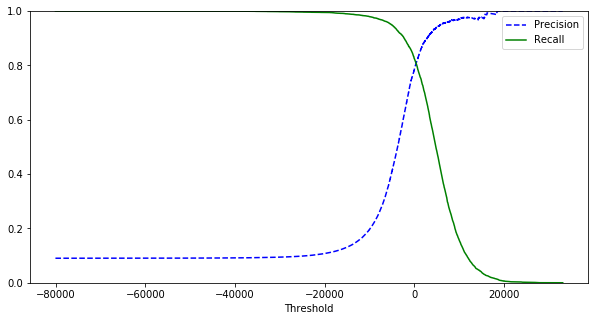

In [70]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(thresholds, precisions[:-1], "b--", label='Precision')
    ax.plot(thresholds, recalls[:-1], "g-", label='Recall')
    ax.set_xlabel('Threshold')
    ax.legend(loc='best')
    ax.set_ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

当阈值提高时，查全率只会降低，所以其曲线更加平滑。而准确率则不然，随着阈值增大，其可能会降低。

现在就可以选择最佳的阈值了，画出准确率和查全率的曲线

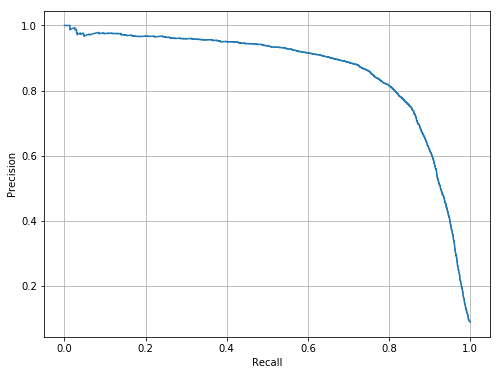

In [78]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(recalls, precisions)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid(True)
plt.show()

可以看到，在召回率80%的时候，准确率急剧下降。你可能会想选择在急剧下降之前 选择出一个准确率/召回率折衷点。比如说，在召回率 60% 左右的点。当然，这取决于你的项目需求。

我们假设你决定达到 90% 的准确率。你查阅第一幅图（放大一些），在 3000 附近找到一个 阈值。为了作出预测（目前为止只在训练集上预测），你可以运行以下代码，而不是运行分 类器的 `predict()` 方法。

In [85]:
y_train_pred_90 = (y_scores > 3000)

In [86]:
precision_score(y_train_5, y_train_pred_90)

0.9024763849885116

In [87]:
recall_score(y_train_5, y_train_pred_90)

0.6520937096476664

很棒！你拥有了一个（近似） 90% 准确率的分类器。它相当容易去创建一个任意准确率的分类器，只要将阈值设置得足够高。但是，一个高准确率的分类器不是非常有用，如果它的召回率太低！

### ROC 曲线